<a href="https://colab.research.google.com/github/Guillem96/noised-mnist-challenge/blob/master/The_Challege_Noised_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt

In [0]:
IMAGE_SIZE = 28

In [0]:
x, y = fetch_openml('mnist_784', return_X_y=True)
y = y.astype(np.int32)

In [0]:
#@title Code to add noise to MNIST images
class Deformation(object):

  def __init__(self, proba):
    self.proba = proba

  def transform(self, x):
    pass

  def __call__(self, x):
    if np.random.random() > self.proba:
      return x
    
    return self.transform(x)

class WhitePatch(Deformation):
  def transform(self, x):
    patch_size = np.random.randint(5, high=15, size=2)
    patch_location = np.random.randint(IMAGE_SIZE/5, IMAGE_SIZE - IMAGE_SIZE/5, size=2)
    x1, y1 = patch_location
    x2, y2 = np.clip(patch_size + patch_location, 0, IMAGE_SIZE - 1)
    x[y1: y2, x1: x2] = 255.
    return x

class DropPixels(Deformation):
  def transform(self, x):
    pix_2_drop = np.random.choice([0, 1], p=[.75, .25], size=(28, 28))
    pix_2_drop = np.where(pix_2_drop)
    x[pix_2_drop] = 255.
    return x

class DeformationPipeline(object):
  def __init__(self, *deformations):
    self.deformations = deformations
  
  def __call__(self, x):
    x = x.reshape(IMAGE_SIZE, IMAGE_SIZE)
    for d in self.deformations:
      x = d(x)
    return x.reshape(-1)

noise_mnist = DeformationPipeline(WhitePatch(7.), 
                                  DropPixels(8.))

In the previous notebook, we trained a model capable of recognizing handwritten digits with high reliability (around 93% f1-score). Furthermore, we did it without much effort. 

But what happens if we add random noise to MNIST images? Will our model learn as well as it did with clean data? Of course not, we will have to tweak our model to improve its ability to generalize with noised data. 

Here is where you are going to be working. Your goal in this challenge is to develop an intelligent model capable of recognizing handwritten digits, even with noise on top of them. 

Now let's take a quick overview to `noised MNIST`.

> In the previous code cell, we developed a pipeline that adds noise to images randomly. Using this code we are going to generate the new MNIST dataset and export it, so you can work with it on your computer.


In [0]:
# Convert add noise to all data
noised_x = np.stack([noise_mnist(o) for o in x])

Plot an image of each class to see the resulting noised data.

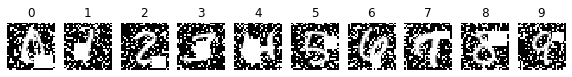

In [6]:
cols = 10
rows = 1
plt.figure(figsize=(10, 10))
for l in range(10): # Digits from 0 to 9
  plt.subplot(rows, cols, l + 1)
  l_digits = noised_x[y == l]
  idx = np.random.randint(0, high=l_digits.shape[0], size=1)
  
  im = l_digits[idx]
  im = im.astype(np.float32) / 255.
  im = im.reshape(28, 28)
  
  plt.title(l)
  plt.imshow(im, cmap='gray')
  plt.axis('off')

As we can see, some numbers are hard to identify even by humans' eyes, but other numbers remains equals as original data. 

As we did in the example notebook, we are going to devide out dataset into a train and a test set, so later we can validate our model and check if it generalizes well to unseen data.

In [0]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.33)

Before starting with the training phase, we first serialize the noised data in order to upload it to a public domain and therefore make the new data set available for people who are taking part in the challenge.

In [0]:
np.savez_compressed('noised-MNIST.npz', x=x_train, y=y_train, x_submission=x_test)
np.savez_compressed('noised-MNIST-secret.npz', x=x_test, y=y_test)

Now, we are going to train the model and evaluate it as we did in the previous notebook and see how the resulting model behaves with the new noised data.

In [8]:
#@title Training code
class ImageScaler(BaseEstimator, TransformerMixin):

  def __init__(self, scale_factor):
    self.scale_factor = scale_factor

  def fit(self, x, y=None):
    return self
  
  def transform(self, x):
    x = x.astype(np.float64)
    x = x / float(self.scale_factor)
    x = np.clip(x, 0, 1.)
    return x

preprocessing_pipeline = Pipeline([('scale', ImageScaler(255)), 
                                   ('standardize', StandardScaler())])

x_train_prep = preprocessing_pipeline.fit_transform(x_train)
rnd_forest = RandomForestClassifier(n_estimators=20, max_depth=10)
rnd_forest.fit(x_train_prep, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=20,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
y_pred = rnd_forest.predict(preprocessing_pipeline.transform(x_test))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85      2316
           1       0.77      0.92      0.84      2634
           2       0.80      0.71      0.75      2274
           3       0.73      0.70      0.71      2315
           4       0.76      0.76      0.76      2218
           5       0.79      0.51      0.62      2055
           6       0.80      0.82      0.81      2285
           7       0.77      0.77      0.77      2447
           8       0.67      0.67      0.67      2286
           9       0.61      0.75      0.67      2270

    accuracy                           0.75     23100
   macro avg       0.75      0.75      0.75     23100
weighted avg       0.75      0.75      0.75     23100



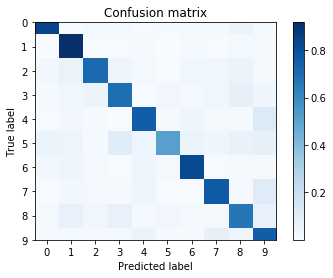

In [10]:
def plot_confusion_matrix(y_true, y_pred,
                          cmap=plt.cm.Blues):

    title = 'Confusion matrix'
    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           title=title,
           ylabel='True label',
           xlabel='Predicted label')


print(classification_report(y_test, y_pred))
plot_confusion_matrix(y_test, y_pred)
plt.show()

As expected, we can see a performance drop on the model, approximately by a 20% of accuracy.

## The challenge

We want you to develop a model using the **noised MNIST dataset** (We are going to provide you a link to download it) and upload your predictions in a csv file.


✔ What is allowed

- You can use any python package
- You can use any data set, even the original MNIST data
- You can share ideas with your friends (but remember the challenge is individual)

⛔ What is forbidden

- You cannot use pretrained models
- Manual intervention, like manual data labeling. We expect you to develop an autonomous system

## Challenge evaluation

To evaluate your submissions we are going to generate different metrics based on your submission file. The metrics that we are going to compute are the ones that we have seen during this 2 notebooks:
- Precision
- Recall
- f1-score
- Confussion Matrix

Apart from the metrics, we are going to evaluate the approach to solve the challenge. So an incredible and innovative approach may be the way to go 🐱.


## How to make a submission

1. Download the provided data from [here](https://firebasestorage.googleapis.com/v0/b/hackeps-2019.appspot.com/o/noised-MNIST.npz?alt=media&token=4cee641b-9e31-42c4-b9c8-e771d2eecbad)
2. Train a model and perform inference on the `x_submission`
3. Upload a txt file containing the predicted labels. Each line will contain the label corresponding to the `nth` instance of the `x_submission` array.

Check the submission example provided [here](https://github.com/Guillem96/noised-mnist-challenge/tree/master/submission-example) 